In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(42)
np.random.seed(42)

# --- 1. Define the FLNN Model ---
class FLNN_ODE_Solver(nn.Module):
    def __init__(self, n_expansion_terms=5):
        super(FLNN_ODE_Solver, self).__init__()

        # n_expansion_terms now represents the maximum degree of the Chebyshev polynomial
        self.n_terms = n_expansion_terms

        # Input dimension = n_terms + 1 (for T_0(x) to T_n_terms(x))
        self.expanded_dim = self.n_terms + 1

        # FLNN has NO hidden layers. Just Expansion -> Output
        self.output_layer = nn.Linear(self.expanded_dim, 1, bias=False)

    def functional_expansion(self, x):
        # Normalize x from [0, 2] to [-1, 1] for Chebyshev polynomials
        # Transformation: x_scaled = 2 * (x - min_x) / (max_x - min_x) - 1
        # For x in [0, 2], this simplifies to x_scaled = x - 1
        x_scaled = x - 1.0

        features = []

        # T_0(x) = 1
        if self.n_terms >= 0:
            features.append(torch.ones_like(x_scaled))

        # T_1(x) = x
        if self.n_terms >= 1:
            features.append(x_scaled)

        # Compute T_n(x_scaled) for n > 1 using the recurrence relation:
        # T_n(x) = 2x * T_{n-1}(x) - T_{n-2}(x)
        if self.n_terms >= 2:
            T_prev2 = torch.ones_like(x_scaled)  # T_0
            T_prev1 = x_scaled                   # T_1
            for i in range(2, self.n_terms + 1):
                T_curr = 2 * x_scaled * T_prev1 - T_prev2
                features.append(T_curr)
                T_prev2 = T_prev1
                T_prev1 = T_curr

        # Concatenate all features along the feature dimension
        return torch.cat(features, dim=1)

    def forward(self, x):
        # Expand input space -> Functional Space
        phi_x = self.functional_expansion(x)

        # Linear combination (The only trainable weights)
        y_pred = self.output_layer(phi_x)
        return y_pred

# --- 2. Training Setup ---

# Hyperparameters
learning_rate = 0.01
epochs = 200
expansion_order = 5  # How many Chebyshev polynomials (up to this degree) to use

# Initialize Model
model = FLNN_ODE_Solver(n_expansion_terms=expansion_order)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create Training Data (Collocation Points)
# Domain x in [0, 2]
x_train = torch.linspace(0, 2, 100).view(-1, 1).requires_grad_(True)

# --- 3. Training Loop ---
print(f"Training FLNN with {model.expanded_dim} functional links...")

loss_history = []

for epoch in range(epochs+1):
    optimizer.zero_grad()

    # A. Forward Pass
    y_pred = model(x_train)

    # B. Compute Gradient dy/dx using AutoGrad
    # This allows us to use the physics/math of the ODE in the loss function
    dy_dx = torch.autograd.grad(outputs=y_pred, inputs=x_train,
                                grad_outputs=torch.ones_like(y_pred),
                                create_graph=True)[0]

    # C. Physics-Informed Loss (ODE Residual)
    # ODE: y' + 2y = 0  =>  Residual = y' + 2y
    ode_residual = dy_dx + 2 * y_pred
    loss_ode = torch.mean(ode_residual**2)

    # D. Boundary Condition Loss
    # BC: y(0) = 1
    x_0 = torch.zeros(1, 1)
    y_0_pred = model(x_0)
    loss_bc = (y_0_pred - 1.0)**2

    # Total Loss
    loss = loss_ode + loss_bc

    # E. Backpropagation
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

Training FLNN with 6 functional links...
Epoch 0: Loss = 7.835523
Epoch 50: Loss = 0.476303
Epoch 100: Loss = 0.032714
Epoch 150: Loss = 0.001170
Epoch 200: Loss = 0.000022


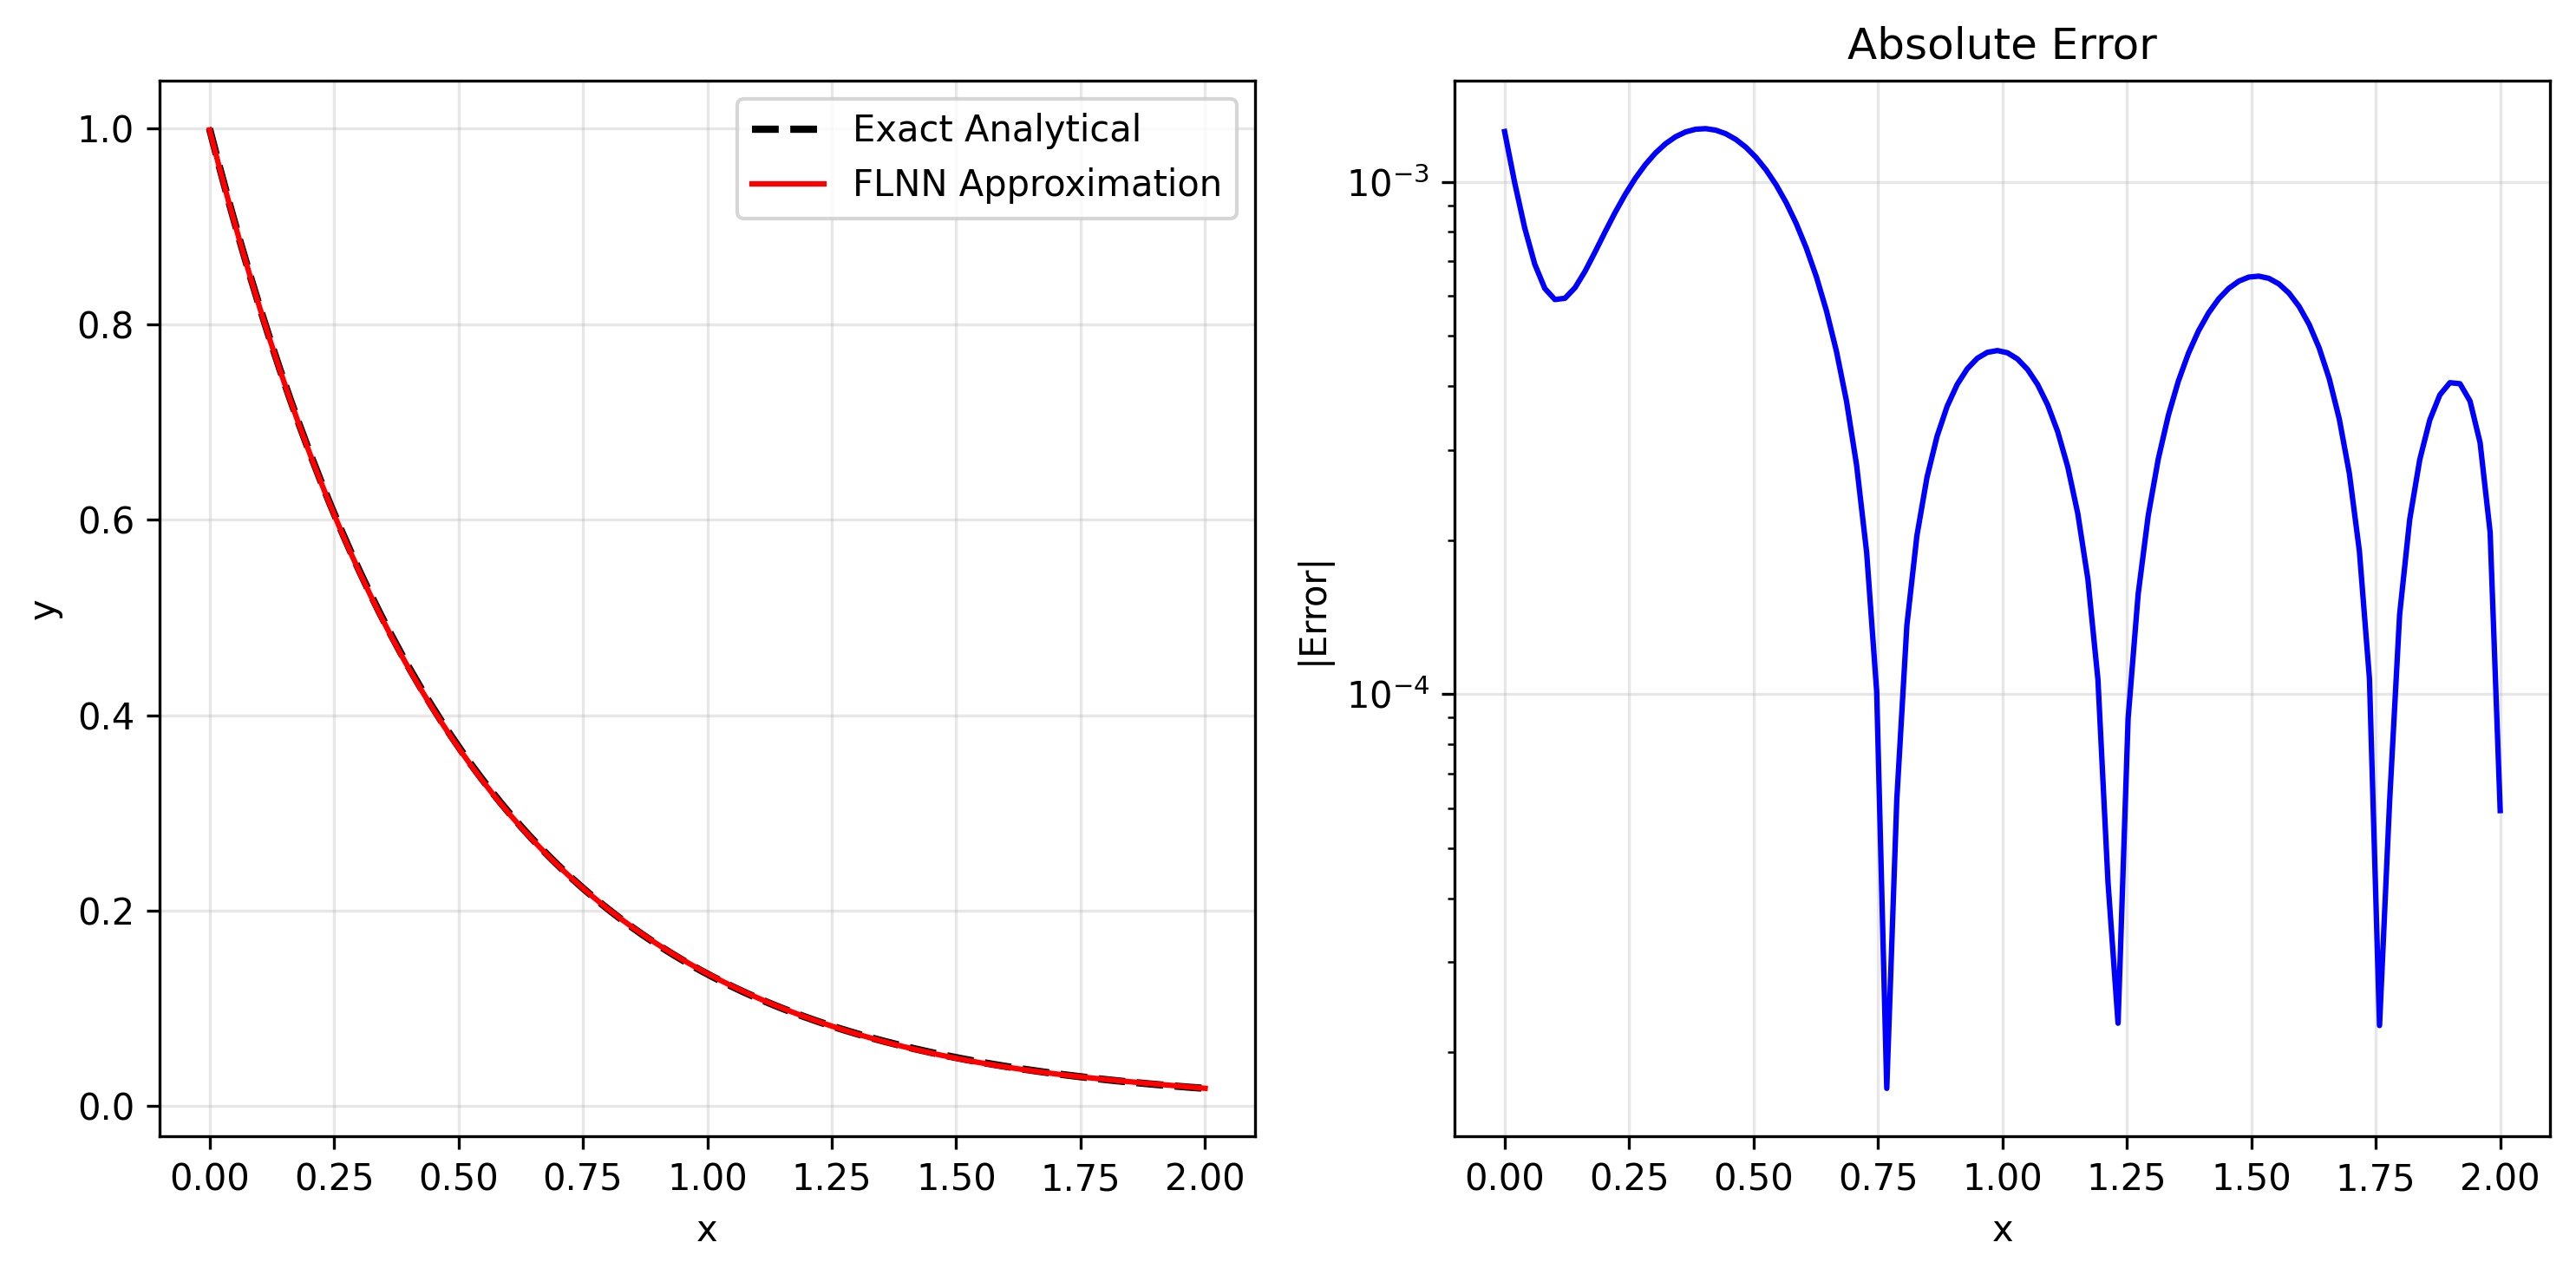

In [ ]:
# --- 4. Visualization ---
with torch.no_grad():
    # Predictions
    x_test = torch.linspace(0, 2, 100).view(-1, 1)
    y_flnn = model(x_test).numpy()

    # Exact Solution: y = e^(-2x)
    y_exact = np.exp(-2 * x_test.numpy())

plt.figure(figsize=(10, 5),dpi=300)

# Plot 1: Comparison
plt.subplot(1, 2, 1)
plt.plot(x_test, y_exact, 'k--', label='Exact Analytical', linewidth=2)
plt.plot(x_test, y_flnn, 'r-', label='FLNN Approximation')
#plt.title(f"Solving y' + 2y = 0\n(Terms={expansion_order}, Linear Weights={model.expanded_dim})")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Error
plt.subplot(1, 2, 2)
plt.plot(x_test, np.abs(y_exact - y_flnn), 'b-')
plt.title("Absolute Error")
plt.xlabel('x')
plt.ylabel('|Error|')
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()